# Cutting plane and bundle methods
The second part of the tutorial focuses on cutting plane and bundle
methods. We aim at resolving the following LASSO problem:
$$
\min_u \;f(u) =  \frac{1}{2} \| A u - b \|_2^2 + \lambda \|u \|_1
$$
with $\lambda$ a given regularization parameter, $A$ and $b$ input data.

## Settings
We import the usual packages:

In [1]:
using Printf, Random
using LinearAlgebra
using ForwardDiff
using JuMP, OSQP
using CPLEX

Fix seed

In [2]:
Random.seed!(2713);

Some constants

In [3]:
const LB = -1e20
const UB =  1e20
const EPS = 1e-8
const SOLVER = CPLEX.Optimizer

CPLEX.Optimizer

We first generate artificial data to study the algorithm:

In [4]:
include("data.jl")

nVariables = 10;
nCassures = 10;
xMin, xMax = build_bounds(nVariables)
A = build_X(nVariables, nCassures, xMin, xMax);
b = randn(nCassures);
λ = 50.0;

Build oracle for objective:

In [5]:
f(u) = 0.5 * norm(A*u - b, 2)^2 + λ * norm(u, 1);

## Cutting plane
The cutting plane method builds a proxy $\underline{f}_k$ for the original
function $f$, such that $\underline{f}_k$ is polyhedral and is a lower approximation:
$$
\underline{f}_k \leq f \quad \forall k
$$
If we have at disposal a collection of point $x_1, \cdots, x_k$,
with associated subgradients $g_1, \cdots, g_k$, the function
$\underline{f}_k$ writes out
$$
\begin{aligned}
f_k(x) = min_x \;& \theta  \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$
Using the JuMP modeler, the master problem at iteration 0 writes as

In [ ]:
function init_master_cutting_plane(model, X, xMin, xMax)
    nVariables, nCassures = size(X)
    x_ = @variable(model, x_[1:nVariables])
    for i in 1:nVariables
        @constraint(model, x_[i] <= xMax[i])
        @constraint(model, x_[i] >= xMin[i])
    end
    α_ = @variable(model, α_ >= LB)
    @objective(model, Min, α_)
    return x_, α_
end;

With these two ingredients, we could define the cutting plane algorithm

In [23]:
function launch_cutting_plane(X, xMin, xMax, maxit=10000)
    master = Model(SOLVER)
    JuMP.set_silent(master)
    #x, α = init_master_cutting_plane(master, X, xMin, xMax)
    
    @variable(master, α >= LB)
    @variable(master,x[1:size(X,1)])
    for i in 1:size(X,1)
        @constraint(master, x[i] <= xMax[i])
        @constraint(master, x[i] >= xMin[i])
    end
    
    lb, ub = LB, UB

    best_ub = ub

    trace_f = Float64[]
    trace_ub = Float64[]
    trace_α = Float64[]
    
    for n_iter in 1:maxit
        println(n_iter)
        JuMP.optimize!(master)
        lb = JuMP.value(α)
        x_k = JuMP.value.(x)
        f_k = f(x_k)
        g_k = ForwardDiff.gradient(f, x_k)
        ub = f_k
        best_ub = min(ub, best_ub)
        push!(trace_f, f_k)
        push!(trace_ub, best_ub)
        push!(trace_α, lb)
        if (lb >= best_ub - EPS) && (best_ub >= lb)
            return trace_f, trace_ub, trace_α
            break
        else
            @constraint(master, α >= f_k + sum( g_k[i]*(x-x_k)[i] for i in 1:size(X,1)))
        end
    end
    return trace_f, trace_ub, trace_α
end;

In [24]:
trace_cutting_plane_f, trace_cutting_plane_ub, trace_cutting_plane_α  = launch_cutting_plane(A, xMin, xMax)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228


([8.881330164947744e6, 3.0417436113853687e6, 3.3284286604732187e6, 2.669421719462124e6, 1.9630103079605657e6, 1.5584280979700633e6, 2.160432903843214e6, 1.7363713835789727e6, 1.1883762811283744e6, 1.2082439925967508e6  …  13.040826370487002, 9.728515111974996, 7.403179169199589, 6.525317189040347, 7.575517426319827, 7.675543621362594, 8.148201068389257, 7.895710493774761, 8.253321574069481, 11.515692361783044], [8.881330164947744e6, 3.0417436113853687e6, 3.0417436113853687e6, 2.669421719462124e6, 1.9630103079605657e6, 1.5584280979700633e6, 1.5584280979700633e6, 1.5584280979700633e6, 1.1883762811283744e6, 1.1883762811283744e6  …  7.7764900022206795, 7.7764900022206795, 7.403179169199589, 6.525317189040347, 6.525317189040347, 6.525317189040347, 6.525317189040347, 6.525317189040347, 6.525317189040347, 6.525317189040347], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  5.490136288793235, 5.1795274776469595, 4.451128173487632, 4.036621331948921, 4.560205015735438, 4.761576385113594, 5

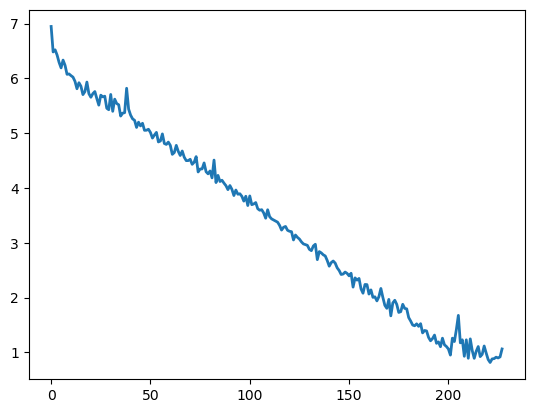

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1710ab1d0>

In [29]:
using PyPlot

plot(log10.(trace_cutting_plane_f), lw=2.)

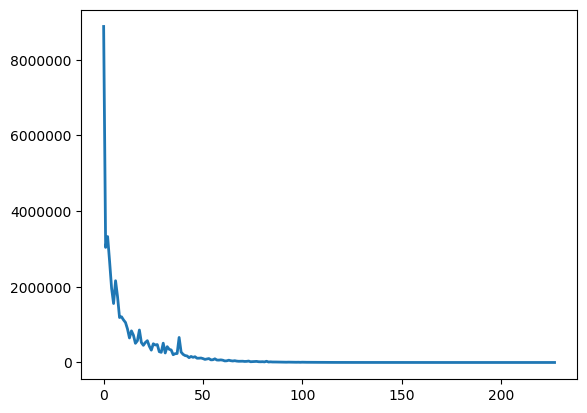

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x171344dd0>

In [31]:
plot(trace_cutting_plane_f, lw=2.)

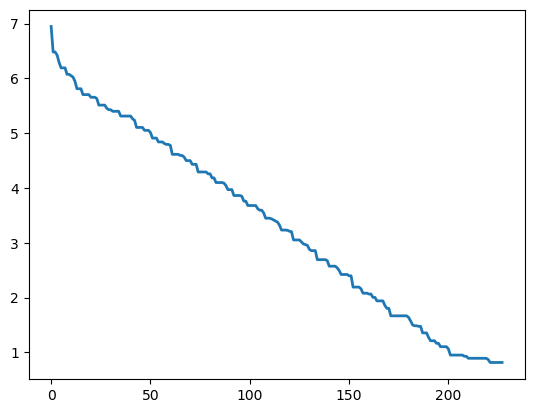

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1713d4710>

In [32]:
plot(log10.(trace_cutting_plane_ub), lw=2.)

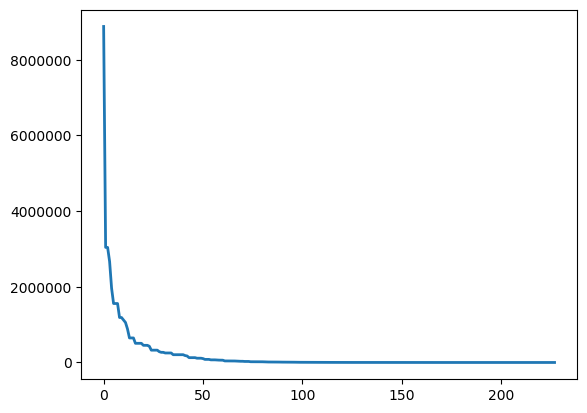

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x17185ca50>

In [33]:
plot(trace_cutting_plane_ub, lw=2.)

## Bundle algorithm
Comparing to the cutting plane method, the bundle algorithm adds a
quadratic penalization to the polyhedral proxy model.
The function .
$$
\begin{aligned}
f_k(x) = min_x \;& \theta + \frac 12 \| x - x_k \|_2^2 \\
         s.t. \quad & \theta \geq g_k^\top (x - x_k) + f(x_k)
\end{aligned}
$$

In [ ]:
function update_center(var_proximal, nVariables, center)
    JuMP.fix.(var_proximal, center)
end

function launch_proximal(X, xMin, xMax, maxit=10000)
    master = Model(SOLVER)
    # Remove annoying logs.
    JuMP.set_silent(master)
    nVariables, nCassures = size(X)
    #x, α = init_master_cutting_plane(master, X, xMin, xMax)
    @variable(master, α >= LB)
    @variable(master, x[1:size(X,1)])
    for i in 1:size(X,1)
        @constraint(master, x[i] <= xMax[i])
        @constraint(master, x[i] >= xMin[i])
    end
    # Add a proximal variable
    var_proximal = @variable(master, var_proximal[1:nVariables])

    stop = false
    lb, ub = -Inf, Inf
    # Best upper bound
    best_ub = ub
    prediction = 0.0
    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    # Maximum number of update
    nb_update = 3
    step = "NONE"
    weight = 1.0
    tol = 1e-1

    # The objective writes out as a QP
    @objective(master, Min, α + sum(weight * var_proximal[i]^2 for i in 1:nVariables))

    center = zeros(nVariables)
    update_center(var_proximal, nVariables, center)

    for n_iter in 1:maxit
        JuMP.optimize!(master)
        lb = JuMP.value(α)
        var_proximal = JuMP.value.(var_proximal)
        x = JuMP.value(x)
        
        x_k = x - var_proximal
        
        f(x_k) - sum(weight * var_proximal[i]^2 for i in 1:nVariables)
        
        if   <= 
            nb_ss += 1
            if
            
            else
                g_k = ForwardDiff.gradient(f, x_k)
            end
        else
            nb_ns += 1
            if
            
            else
                g_k = ForwardDiff.gradient(f, x_k)
            end
        end
    end
end

In [ ]:
function launch_bundle(X, xMin, xMax, maxit=10000)
    master = Model(with_optimizer(SOLVER))
    # Remove annoying logs.
    JuMP.set_silent(master)
    nVariables, nCassures = size(X)
    #x, α = init_master_cutting_plane(master, X, xMin, xMax)
    @variable(master, α >= LB)
    @variable(master,x[1:size(X,1)])
    for i in 1:size(X,1)
        @constraint(master, x[i] <= xMax[i])
        @constraint(master, x[i] >= xMin[i])
    end
    # Add a proximal variable
    y = @variable(master, y[1:nVariables])

    stop = false
    lb, ub = -Inf, Inf
    # Best upper bound
    best_ub = ub
    prediction = 0.0
    # Number of serious step
    nb_ss = 0
    # Number of null step
    nb_ns = 0
    # Maximum number of update
    nb_update = 3
    step = "NONE"
    weight = 1.0
    tol = 1e-1

    # The objective writes out as a QP
    @objective(master, Min, α + sum(weight * (y[i]-x[i])^2 for i in 1:nVariables))

    center = zeros(nVariables)
    x_k = zeros(nVariables)
    f_k = f(x_k)
    y_k = zeros(nVariables)
    #update_center(var_proximal, nVariables, center)

    for n_iter in 1:maxit
        JuMP.optimize!(master)
        lb = JuMP.value(α)
        y_k = JuMP.value.(y)
        #Projected decrease
        prediction = f_k - (lb + weightsum((y_k[i]-x_k[i])^2 for i in 1:nVariables))
        if prediction < tol
            break
        else
            fy_k = f(y_k)
            if f_k - fy_k >= 0.5prediction
                x_k = y_k
            else
                g_k = ForwardDiff.gradient(f, y_k)
                @constraint(master, α >= fy_k + sum(g_k[i]*(y[i]-y_k[i]) for i in 1:nVariables))
            end
        end 
    end
end

In [ ]:
#trace_cutting_plane_f, trace_cutting_plane_ub, trace_cutting_plane_α  = launch_cutting_plane(A, xMin, xMax)